# Validation of ESG module

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from source.noise import NoiseGenerator
from source.esg import EconomicScenarioGenerator

In [2]:
N = 100000
interval = 12
T = 5
steps = interval * T

### Simulation parameters

In [3]:
with open('./data/params.pkl', 'rb') as f:
     s0, Corr, variance, mean, ar = pickle.load(f)

In [4]:
s0

EQ_SWE          224.480000
EQ_WORLD       4041.233665
ALTERNATIVE     100.000000
CPI             278.000000
PROPERTY        100.400000
IR_1              0.029400
IR_5              0.039880
IR_15             0.048920
SPREAD            0.003790
Name: 2003-12-31, dtype: float64

### Pick index of a stock and a rate

In [5]:
Si = np.where(s0.index == 'EQ_SWE')[0][0]
ri = np.where(s0.index == 'IR_1')[0][0]

In [6]:
S0 = s0.to_numpy()[[Si, ri]]
a = ar.to_numpy()[[Si, ri]]
mu = mean.to_numpy()[[Si, ri]]
sigma = np.sqrt(variance.to_numpy()[[Si, ri]])
corrmatrix = Corr.to_numpy()[np.ix_([Si,ri],[Si,ri])]

## Simulate

In [7]:
NG = NoiseGenerator()
dB = NG.normal_steps(corrmatrix, N * steps)

In [8]:
dB.shape

(2, 6000000)

In [9]:
ESG = EconomicScenarioGenerator(S0, a, mu, sigma, dB)
AK, RB = ESG.get_scenarios(N, steps, interval)

### Stocks

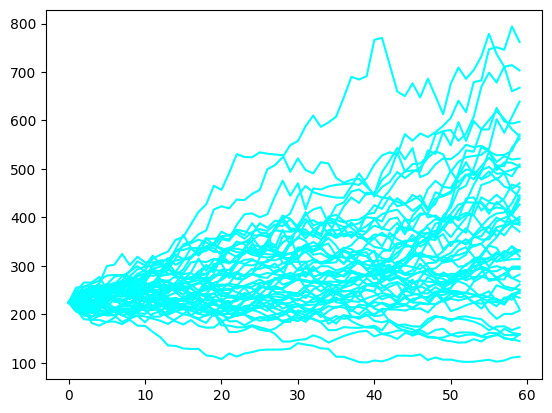

In [10]:
for s in AK[:50]:
    plt.plot(s.T, color='cyan')

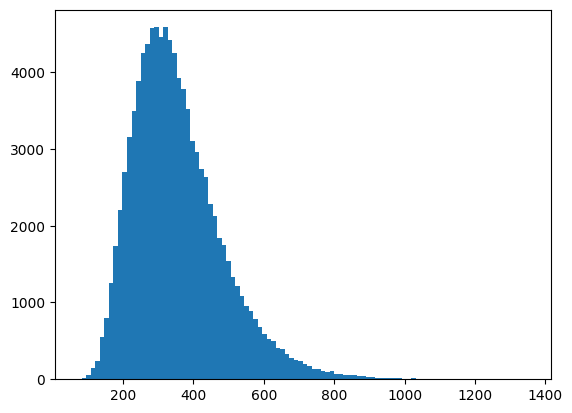

In [11]:
counts, bins = np.histogram(AK[:,:,-1], bins=100)
plt.hist(bins[:-1], bins, weights=counts);

Log-normal

### Values in 1% quantiles

In [12]:
[bins[1],bins[99]]

[82.81497141468766, 1339.0795229804212]

### Rates

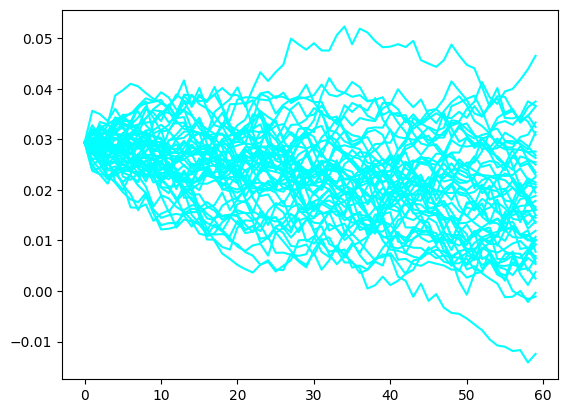

In [13]:
for r in RB[:50]:
    plt.plot(r.T, color='cyan')

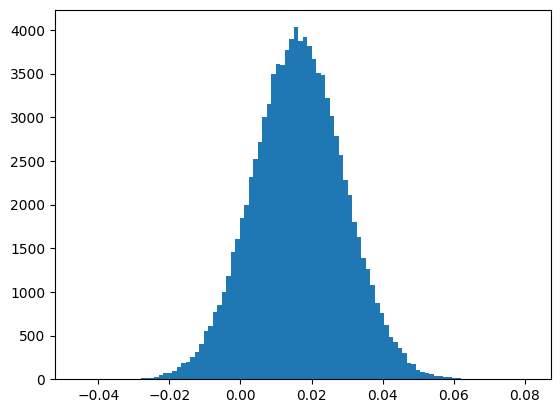

In [14]:
counts, bins = np.histogram(RB[:,:,-1], bins=100)
plt.hist(bins[:-1], bins, weights=counts);

Normal

## Validate

In [15]:
sim_stock_returns = np.diff(np.log(np.squeeze(AK)))
#sim_stock_returns = np.diff(np.squeeze(AK))
sim_rate_returns = np.diff(np.squeeze(RB))

### Correlation

In [16]:
np.corrcoef(sim_stock_returns.flatten(), sim_rate_returns.flatten())[0, 1]

0.2026941084216139

In [17]:
corrmatrix[0, 1]

0.2028056013640747

### Variance

In [18]:
np.diag(np.cov(sim_stock_returns.flatten(), sim_rate_returns.flatten())) * interval

array([2.55103715e-02, 5.08679939e-05])

In [19]:
sigma**2

array([2.57727660e-02, 5.07720393e-05])

### Mean

$E[S_T] = S_0 e^{\mu T}$

In [20]:
np.mean(AK[:,0,-1])

356.11578161161736

In [21]:
S0[0] * np.exp(mu[0] * T)

359.68157778016155

 $E[r_T] = r_0 e^{-aT} + \mu (1 - e^{-aT})$

In [22]:
np.mean(RB[:,0,-1])

0.016347317556139877

In [23]:
S0[1] * np.exp(-a[1] * T) + mu[1] * (1 - np.exp(-a[1] * T))

0.016251581081708114